# Data Wrangling

From the EDA, we can see some places  

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv", index_col=0)

In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Already we can see some columns have `NaN` values, so lets take a look at the df info to see more.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

There are 1460 total entries, but many columns do not have 1460 Non-null entries. Lets get a list of which columns and what those columns tell us.

In [5]:
nan_columns = df.columns[df.isna().any()].tolist()

In [6]:



s = ''
for i in nan_columns:
    s += "- " + i + "\n"

display(Markdown("So the following columns have null values: \n"))

display(Markdown(s))

So the following columns have null values: 


- LotFrontage
- Alley
- MasVnrType
- MasVnrArea
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- Electrical
- FireplaceQu
- GarageType
- GarageYrBlt
- GarageFinish
- GarageQual
- GarageCond
- PoolQC
- Fence
- MiscFeature


Let's investigate what those columns tell us.

- LotFrontage: linear feet of street connected to property, float64
- Alley: Type of alley, string either Pave, Grvl, NA (none). 
- MasVnrType: masonry veneer type. String BrkCmn, BrkFace, CBlock, None, Stone.
- MasVnrArea: sqft of masonry veneer, float64
- BsmtQual: height of basement, string Ex, Gd, TA, Fa, Po, NA (no basement)
- BsmtCond: General condition of the basement, string Ex, Gd, TA, Fa, Po, NA (no basement)
- BsmtExposure: Walkout or garden level walls. String Gd, Av, Mn, No, NA (no basement)
- BsmtFinType1: Rating of finished area of basement, string GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA (no basement)
- BsmtFinType2: Rating of second finished area (if exists). string GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA (no basement)
- Electrical: electrical system. String SBrkr, FuseA, FuseF, FuseP, Mix
- FireplaceQu: fireplace quality. String Ex, Gd, TA, Fa, Po, NA (no fireplace)
- GarageType: Garage location. String 2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA (no garage)
- GarageYrBlt: Year, float64
- GarageFinish: Interior garage finish. String Fin, RFn, Unf, NA (no garage)
- GarageQual: Garage Quality. String Ex, Gd, TA, FA, Po, NA
- GarageCond: Garage condition. String Ex, Gd, TA, FA, Po, NA
- PoolQC: Pool quality. String Ex, Gd, TA, FA, NA
- Fence: Fence Quality. String GdPrv, MnPrv, GdWo, MnWw, NA
- MiscFeature: Misc feature not covered elsewhere. String Elev, Gar2, Othr, Shed, TenC, NA (none)

Key takeaway: many of these have NA options, or 0 would be a sensical value (for example, LotFrontage), so if the entry simply wanted to convey the home not having a value for that feature, they should have included NA or 0, not Null.

The exception is GarageYrBlt, which expects a float and entering 0000 would be strange. So its worth looking at GarageType and GarageYrBlt to see if some of the Null's line up.

Next, it will be helpful to visualize the null entries. This will help us see whether it might be feasible to fill the null values, or if we need to drop the rows or columns.



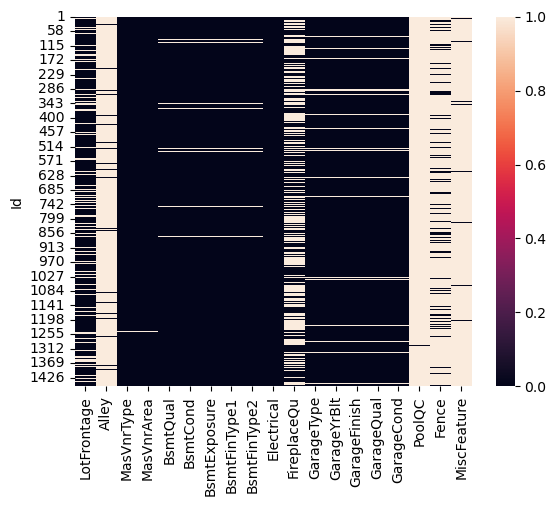

In [7]:
sns.heatmap(df[df.columns[df.isna().any()].tolist()].isna())
plt.savefig("null_heatmap.png")

Clearly Alley, PoolQC, Fence, and MiscFeature have the most null, with FireplaceQu not far behind.

In [8]:
df[df.columns[df.isna().any()].tolist()].count().apply(lambda x: 1460 - x)



LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

From the above, we can see that many columns have very few null values. Electrical, MasVnrType and MasVnrArea have fewer than 10 null. The various garage columns all have 81 null, which may mean that the same 81 entries are missing that info, and it may be safe to conclude that the property has no garage. Similarly for Bsmt columns. SOme further investigation may  PoolQC, Fence, MiscFeature, and Alley have more than 1000 null values. However, those may be important features to valuation for the entries that do have them (having a pool is likely to raise the valuation all else being equal).

## Clean Garage Columns
Let's start with the garage columns. As I said above, it seems likely that the data is not missing completely at random, since the same number of points is missing for all cols. Since there are only 81 missing points, it should be easy enough to just print those points to a csv and manually inspect.

In [9]:
garage_cols = df[[col for col in df.columns if 'Garage' in col]]

garage_cols = garage_cols[garage_cols.isna().any(axis=1)]

In [10]:
garage_cols.to_csv("garage_cols.csv")

This confirms that all null rows for data related to garages are null for all garage columns except number of cars and sqftage, which are both always 0. Thus, it seems plausible to infer that these null values should be set to the appropriate NA/No garage value. The one chalenge left is what to do with GarageYrBlt, which is a float64 and has no obvious NA value. I'll look into this more later, but since GarageYrBlt = 0 is predicted by GarageType = NA, I **think** just setting it to 0 should be okay.

In [11]:
df['GarageYrBlt'].fillna(0, inplace=True)

In [12]:
df['GarageYrBlt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,    0., 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [13]:
df.fillna({'GarageType': "NA", 'GarageFinish': "NA", 'GarageQual': "NA", 'GarageCond': "NA"}, inplace=True)

## Clean Bsmt Columns
Lets work on the Basement columns now (BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2)

In [14]:
bsmt_cols = df[[col for col in df.columns if 'Bsmt' in col]]

bsmt_cols = bsmt_cols[bsmt_cols.isna().any(axis=1)]

bsmt_cols.to_csv("bsmt_cols.csv")

From visual inspection, rows 332 and 948 seem to be Missing completely at random, but can probably be inferred. The others appear to have no basement information, so we will fill them with the relevant NA/No basement value.

First, we should deal with 332 and 948.

332 is missing FinType2, but has a BsmtFinSF2 value. Its not unfinished because the numbers don't work out, so I'll go with the mode of the column other than Unf, 'Rec'. 948 is missing 'BsmtExposure' so we will replace with column mode, 'No' as well.

In [15]:
fill_val = df['BsmtFinType2'].value_counts()[1:2].index.to_list()[0]
# df.loc[(332, 'BsmtFinType2')] = fill_val
fill_val = df['BsmtExposure'].value_counts()[0:1].index.to_list()[0]
# df.loc[(948, 'BsmtExposure')] = fill_val

In [16]:

df.fillna({"BsmtQual": "NA", "BsmtCond": "NA", "BsmtExposure": "NA", "BsmtFinType1": "NA", "BsmtFinType2": "NA"}, inplace=True)


## Electrical 
That completes the cleaning for Basement columns. Let's take stock of where we are.

In [17]:
df[df.columns[df.isna().any()].tolist()].count().apply(lambda x: 1460 - x)


LotFrontage     259
Alley          1369
MasVnrType        8
MasVnrArea        8
Electrical        1
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

Electrical is only missing in 1 row so let's take care of that. Knob and Tube wiring is very old and no longer code, so any new construction would not have it. Similarly, no new construction (newer than ~1970 certainly) would have a fuse box. So let's check the build date.

In [18]:
df.loc[df['Electrical'].isna()]['YearBuilt']

Id
1380    2006
Name: YearBuilt, dtype: int64

Its very safe to conclude this home has a circuit breaker and romex wiring. 

In [41]:
df.loc[(1380, 'Electrical')] = 'SBrkr'

## Veneer

There are 8 missing entries for masonry veneer columns. Let's check them out

In [20]:
mas_cols = df.loc[df['MasVnrType'].isna()]

In [21]:
mas_cols.to_csv("masvnrtype.csv")

The same rows are nan for both, so lets set them to None/0

In [22]:
df.fillna({"MasVnrType": "None", "MasVnrArea": 0.0}, inplace=True)

## PoolQC

Now to clean up the pool columns. There are two, one indicating the quality and one indicating the SqFt of pool. If 'PoolArea' is 0 and PoolQC is nan, it seems reasonable to conclude that the property has no pool.



In [23]:
df.loc[(df['PoolQC'].isna()) & (df['PoolArea'] == 0.0), 'PoolQC'] = 'NA'

In [36]:
df['PoolQC'].isna().unique()

array([False])

In [25]:
df.loc[df['PoolQC'] != 'NA']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,...,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000
1171,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,...,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1387,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000
1424,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


## Take stock

In [26]:
df[df.columns[df.isna().any()].tolist()].count().apply(lambda x: 1460 - x)

LotFrontage     259
Alley          1369
Electrical        1
FireplaceQu     690
Fence          1179
MiscFeature    1406
dtype: int64

## Lot Frontage

This value indicates the number of feet of street the property connects to. Would expect this to be nonzero for all entries, so filling with the mean seems plausible. Perhaps adjusting for lot size would be smarter but let's try this.

In [27]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)

## Alley/Fence
Alley is missing a lot of entries, we won't be able to get a good idea of what these values should be. Same with fence. For this first try, I think dropping them is a good idea. They likely don't have a huge impact on home price.

In [28]:
df.drop(['Alley', 'Fence'], axis=1, inplace=True)

In [29]:
df[df.columns[df.isna().any()].tolist()].count().apply(lambda x: 1460 - x)

Electrical        1
FireplaceQu     690
MiscFeature    1406
dtype: int64

## Fireplaces

Let's see if the rows missing 'FireplaceQu' have 0 fireplaces

In [30]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [31]:
df.loc[df['FireplaceQu'].isna()]['Fireplaces'].unique()

array([0])

All rows that have nan for quality have 0 Fireplaces listed (and vice-versa, actually). So its likely that they just do not have fireplaces. Fill nan with 'NA'

In [32]:
df['FireplaceQu'].fillna('NA', inplace=True)

## MiscFeature

Yay, one more left! 'MiscFeature' does have an 'NA' option, and since there's otherwise no clear reason why the nan would be related to other features, it makes sense to fill them with 'NA'


In [33]:
df['MiscFeature'].fillna('NA', inplace=True)

In [42]:
df[df.columns[df.isna().any()].tolist()].count().apply(lambda x: 1460 - x)

Series([], dtype: int64)

# Data Cleaning Over

In [43]:
df.to_csv("train_clean.csv")